In [1]:
import numpy as np
import os
import glob
import pandas as pd 
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt


Import Data

In [2]:
##------------------------------------------------------------------##
##                             Import                               ##
##  I did a pretty in-depth walkthrough of the BHM code in the      ##
##  methods document, so I won't go into as much detail here about  ##
##  the overall scheme. Instead, I'll be annotating lines to        ##
##  clarify what they specifically do. I'll also put brief          ##
##  explanatory bits at the top as necessary.                       ##
##------------------------------------------------------------------##

fileshare = '/Volumes/UCDN/datasets/DDT/'
split_dir = os.path.join(fileshare,'split')
subj_files = glob.glob(os.path.join(split_dir,'23_DDT*/cdd/23_DDT*_cdd.csv'))
cols = ['cdd_choice','cdd_immed_amt','cdd_delay_amt','cdd_immed_wait','cdd_delay_wait','alpha']
data = pd.DataFrame(columns=['subject']+cols)

for subj_id,fn in enumerate(sorted(subj_files)):
    subj = os.path.basename(fn).replace('_cdd.csv','')
    # print('Working on file: {}'.format(os.path.basename(fn)))
    df = pd.read_csv(fn,index_col=0)
    df = df.reset_index(drop=True)
    df['subject'] = subj
    df['alpha'] = 1.0
    for c in cols:
        df[c] = df[c].astype(float)
    df['subject_id'] = subj_id
    data = pd.concat([data,df],ignore_index=True)
    
print(data)

          subject  cdd_choice  cdd_immed_amt  cdd_delay_amt  cdd_immed_wait   
0    23_DDT_002_1         0.0          850.0         1000.0            0.00  \
1    23_DDT_002_1         0.0          750.0         1000.0            0.00   
2    23_DDT_002_1         0.0          950.0         1000.0            0.00   
3    23_DDT_002_1         1.0           83.0         1000.0            0.00   
4    23_DDT_002_1         1.0           63.0         1000.0            0.00   
..            ...         ...            ...            ...             ...   
387  23_DDT_109_2         1.0          494.0         1000.0            0.00   
388  23_DDT_109_2         1.0          950.0         1000.0            0.00   
389  23_DDT_109_2         1.0          450.0         1000.0            0.00   
390  23_DDT_109_2         1.0           50.0         1000.0            0.25   
391  23_DDT_109_2         0.0           50.0         1000.0            0.00   

     cdd_delay_wait  alpha  subject_id  
0         

In [3]:
subjects = data['subject'].unique()
nb_subj = subjects.shape[0]
nb_trials = data.shape[0]//nb_subj
subj_id = [int(s) for s in data['subject_id'].to_list()]
# np.array([ [s]*nb_trials for s in range(nb_subj) ]).flatten()

delay_amt = data['cdd_delay_amt'].values
delay_wait = data['cdd_delay_wait'].values
immed_amt = data['cdd_immed_amt'].values
immed_wait = data['cdd_immed_wait'].values
choices = data['cdd_choice'].values

print(subjects)

['23_DDT_002_1' '23_DDT_002_2' '23_DDT_109_1' '23_DDT_109_2']


In [4]:
print(type(choices[0]))

<class 'numpy.float64'>


In [5]:
save_dir = 'csv'
fn = os.path.join(save_dir,'completely_pooled_model_IDM.csv')
pool_model = pd.read_csv(fn,index_col=0)

mu_kappa_hat,std_kappa_hat = pool_model.loc['kappa[0]','mean'],pool_model.loc['kappa[0]','sd']
mu_gamma_hat,std_gamma_hat = pool_model.loc['gamma[0]','mean'],pool_model.loc['gamma[0]','sd']

print('For kappa, use the following (mu,sigma) : ({},{})'.format(mu_kappa_hat, std_kappa_hat))
print('For gamma, use the following (mu,sigma) : ({},{})'.format(mu_gamma_hat, std_gamma_hat))

For kappa, use the following (mu,sigma) : (0.0199494192,0.0004967748)
For gamma, use the following (mu,sigma) : (0.1290928433,0.0027119263)


## Working set
The sets of parameters below seem to be generating posterior for kappa and gamma that have some variability... is it corect? Not sure, we have to plot against MLE and find out, or we can use the estimates to generate a softmax

In [6]:

# We will fit a model for each subject
with pm.Model() as model_simple:

    # Hyperparameters for k
    # mu_kappa_hyper = pm.Beta('mu_kappa_hyper',mu=mu_kappa_hat,sigma=0.1)
    sd_kappa_hyper = pm.Beta('sd_kappa_hyper',mu=std_kappa_hat,sigma=0.01)

    # use above mean and stdev to define kappa and gamma, the posterior  from the pooled is now our prior
    # kappa = pm.Beta('kappa',mu=mu_kappa_hyper,sigma=std_kappa_hat,shape=np.size(np.unique(subj_id)))
    kappa = pm.HalfNormal('kappa',sigma=sd_kappa_hyper,shape=np.size(np.unique(subj_id)))
    gamma = pm.HalfNormal('gamma',sigma=0.02,shape=np.size(np.unique(subj_id)))
    
    prob = pm.Deterministic('prob', 1 / (1 + pm.math.exp(-gamma[subj_id] * ( delay_amt/(1+(kappa[subj_id]*delay_wait)) 
                                                                            - immed_amt/(1+(kappa[subj_id]*immed_wait)) ))))

    y_1 = pm.Bernoulli('y_1',p=prob,observed=choices)

    trace_prior = pm.sample(10000, tune=10000, cores=5,target_accept=0.95)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [sd_kappa_hyper, kappa, gamma]


Sampling 5 chains for 10_000 tune and 10_000 draw iterations (50_000 + 50_000 draws total) took 107 seconds.


Saving to : csv/simple_BH_model_working_set.csv


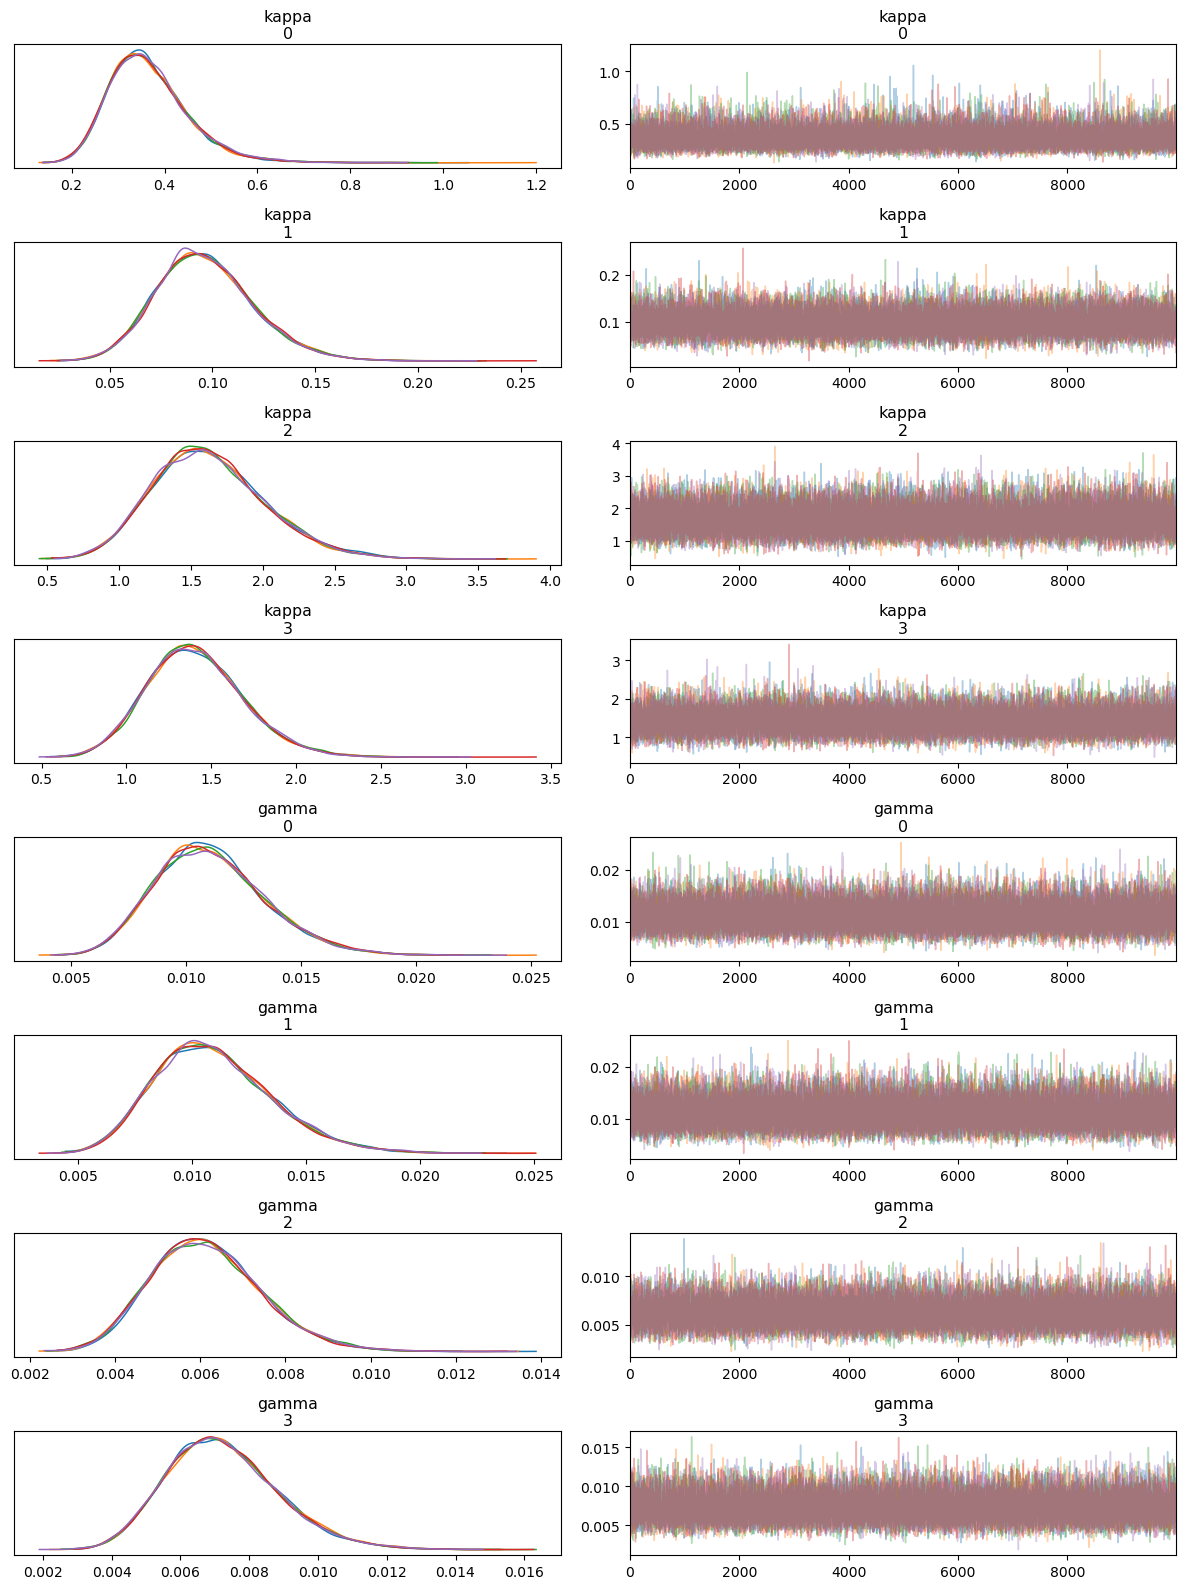

In [7]:

# increase number of subplots
az.rcParams["plot.max_subplots"] = 600
# Call the trace whatever you like. This just saves it. You don't want to run a whole model and then accidentally x-out your window or refresh or something and lose it all!
az.plot_trace(trace_prior, var_names=["kappa","gamma"],compact=False)
plt.tight_layout()
# This is how you get a nice array. Note that this returns a pandas DataFrame, not a numpy array. Indexing is totally different.
summary= az.summary(trace_prior,round_to=10)
fn = os.path.join(save_dir,"simple_BH_model_working_set.csv")
# Again, call it what you want (yeah - call it what you want tooooo)
print('Saving to : {}'.format(fn))
summary.to_csv(fn)

array([[<Axes: ylabel='kappa\n0'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='kappa\n1'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='kappa\n2'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='kappa\n3'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='gamma\n0'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='gamma\n1'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='gamma\n2'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='kappa\n0', ylabel='gamma\n3'>,
        <Axes: xlabel='kappa\n1'>, <Axes: xlabel='kappa\n2'>,
        <Axes: xlabel='kappa\n3'>, <Axes: xlabel='gamma\n0'>,
        <Axes: xlabel='g

<Figure size 640x480 with 0 Axes>

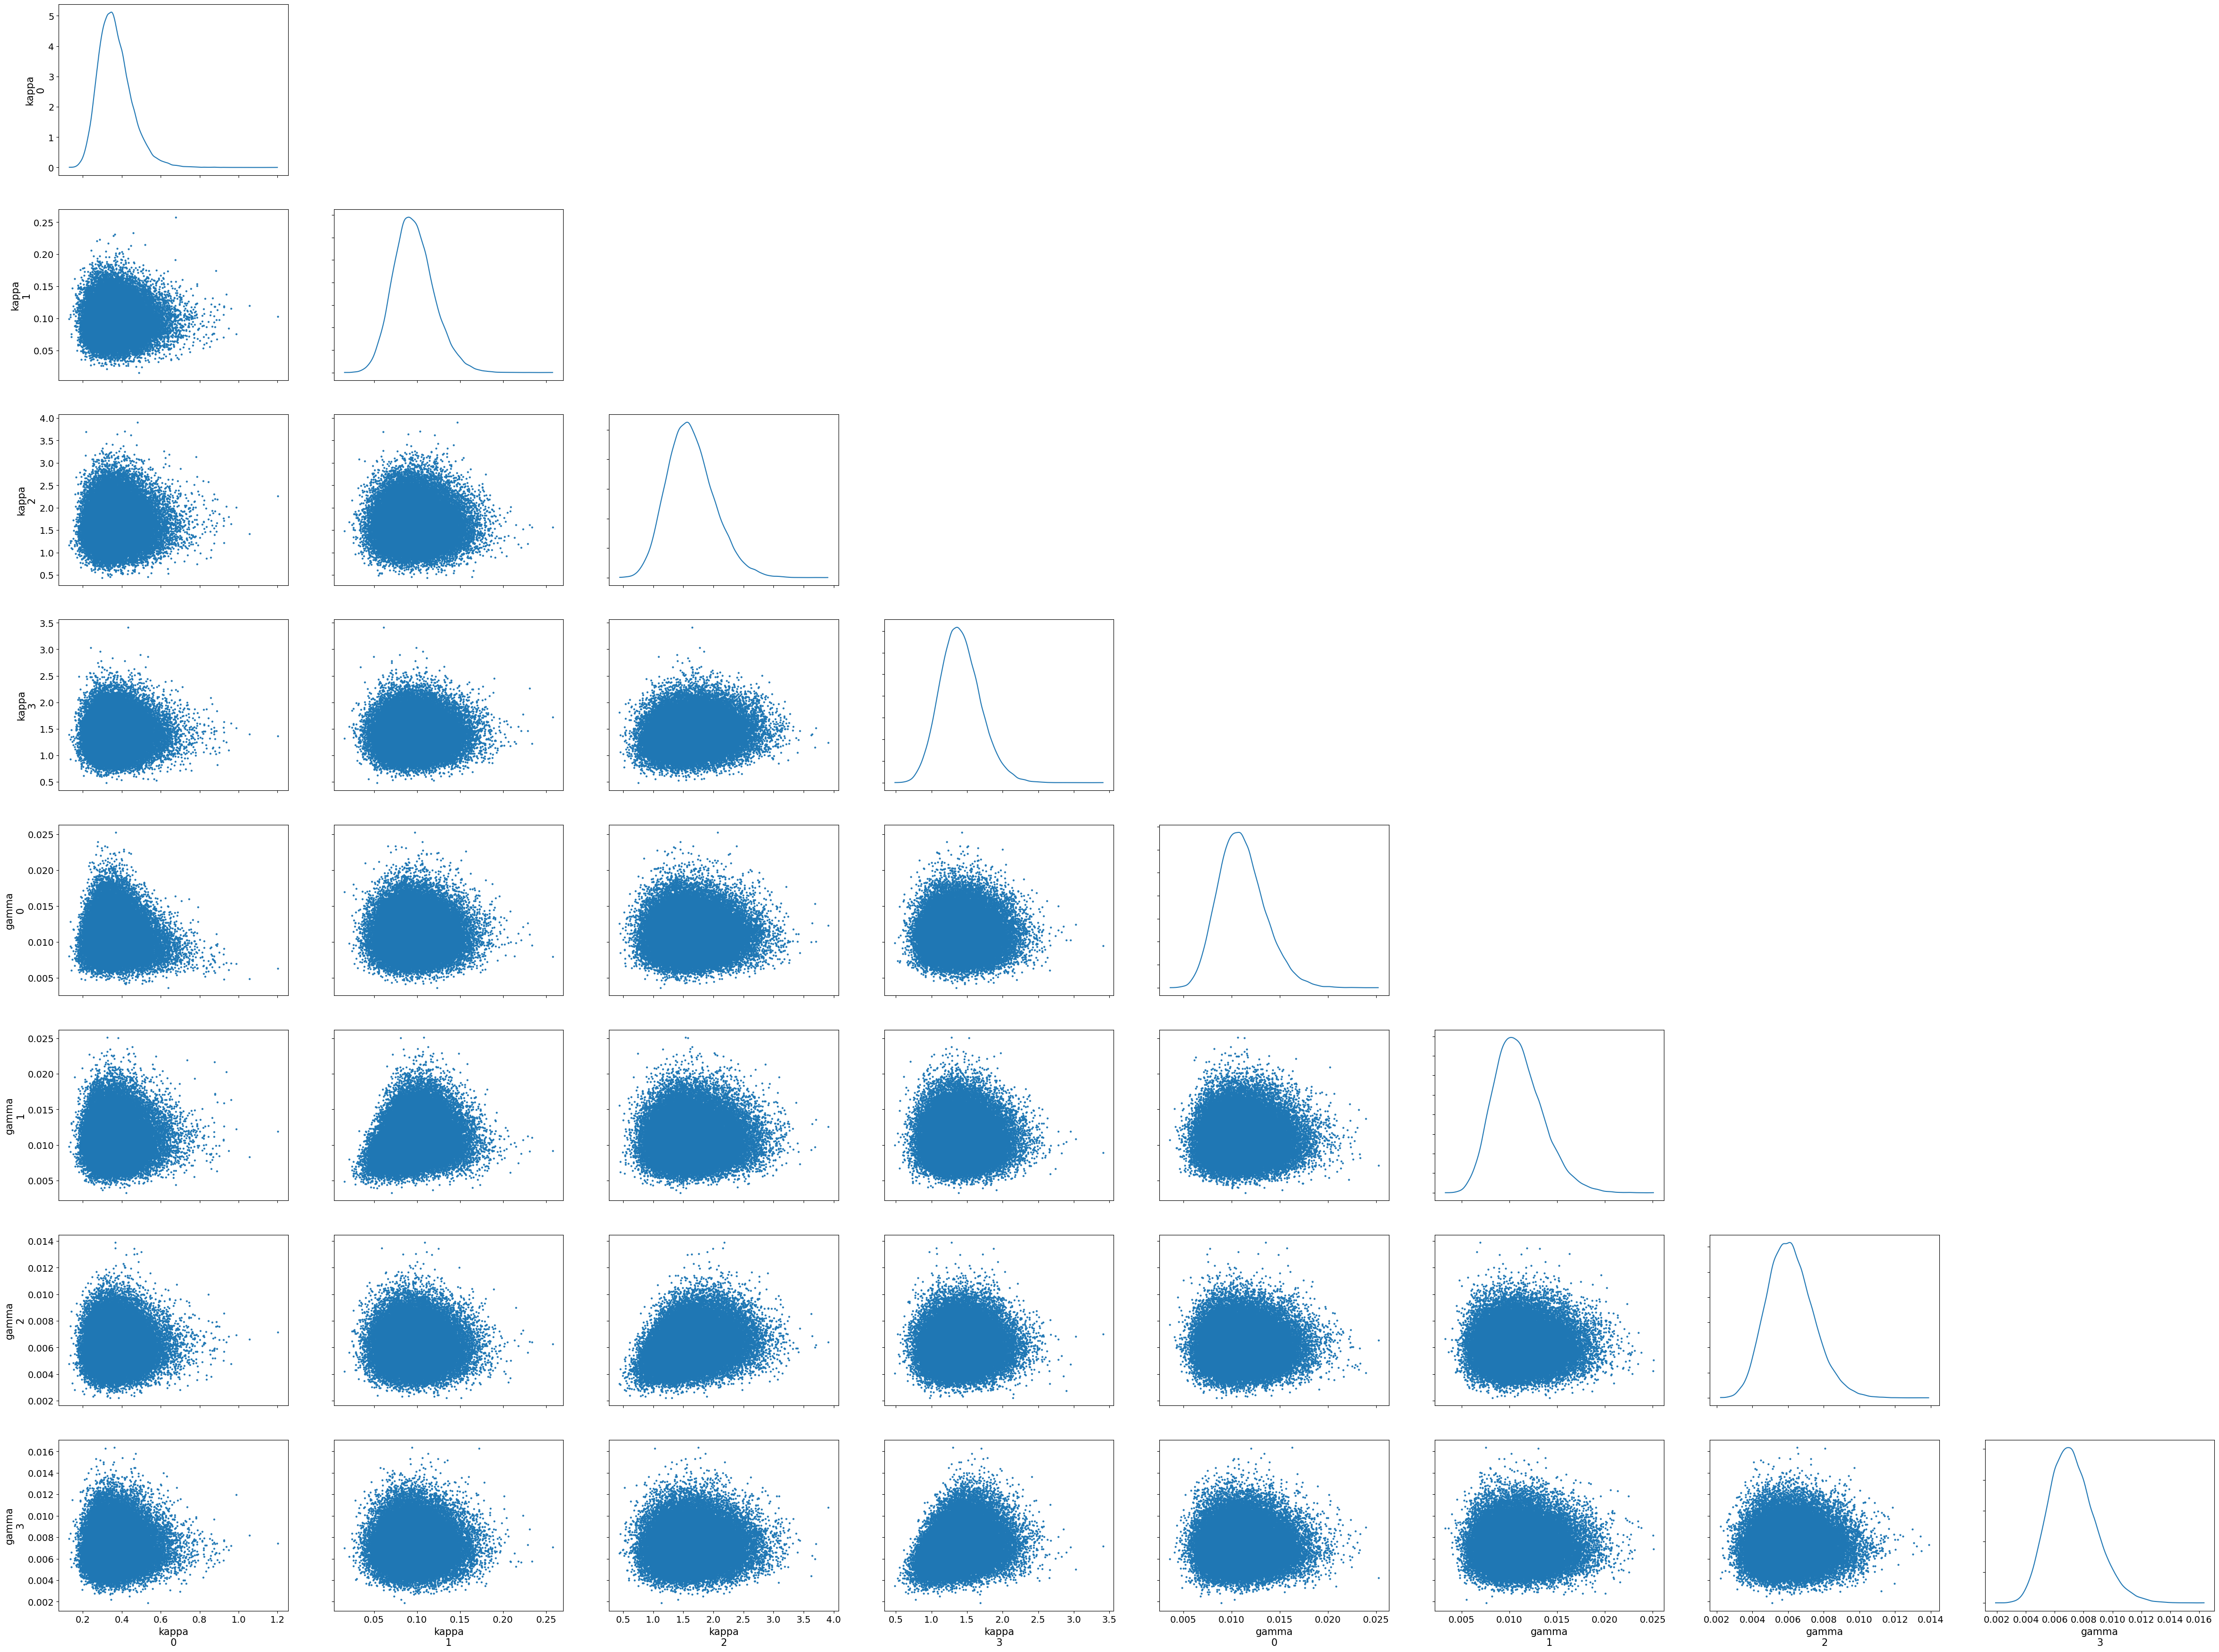

In [8]:
plt.figure()
az.plot_pair(trace_prior, var_names=["kappa","gamma"],marginals=True)

array([[<Axes: title={'center': 'kappa\n0'}>,
        <Axes: title={'center': 'kappa\n1'}>,
        <Axes: title={'center': 'kappa\n2'}>,
        <Axes: title={'center': 'kappa\n3'}>],
       [<Axes: title={'center': 'gamma\n0'}>,
        <Axes: title={'center': 'gamma\n1'}>,
        <Axes: title={'center': 'gamma\n2'}>,
        <Axes: title={'center': 'gamma\n3'}>]], dtype=object)

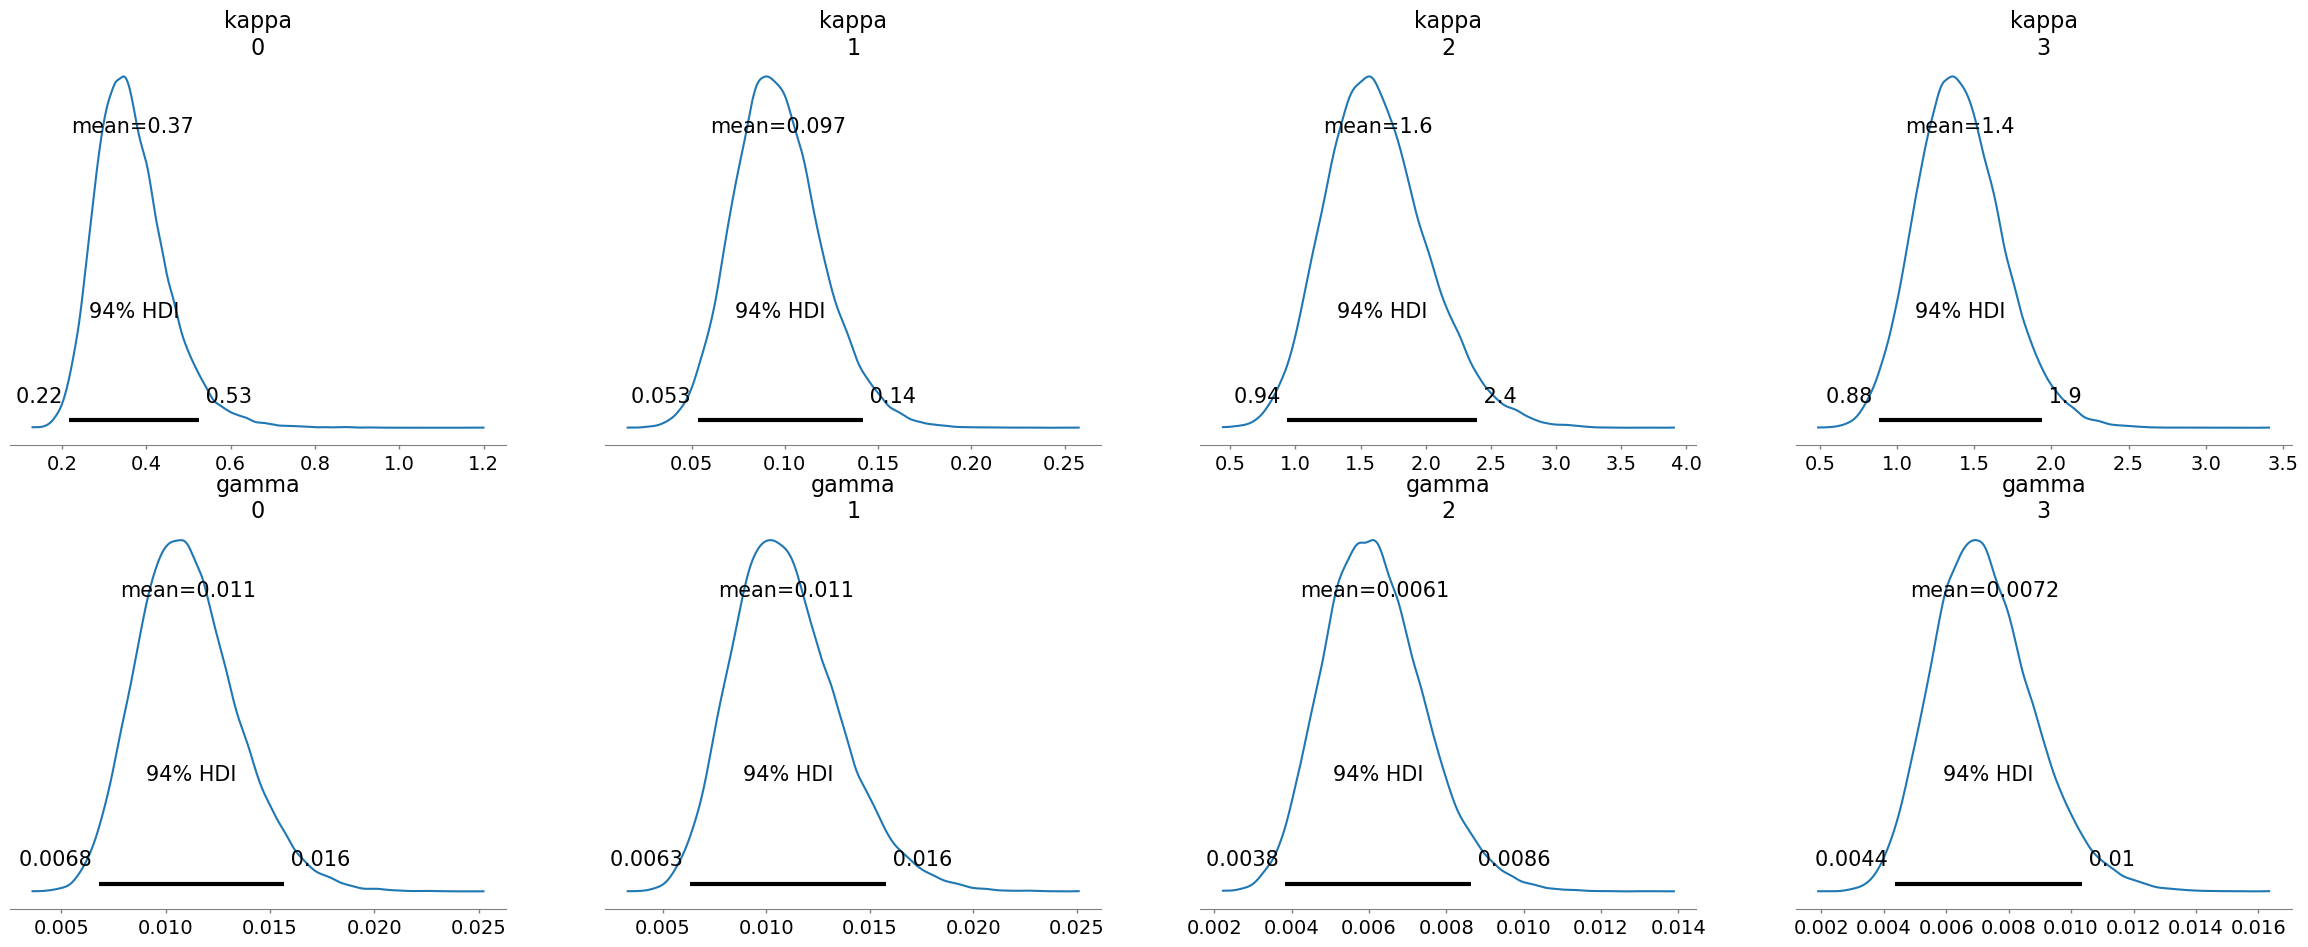

In [9]:
az.plot_posterior(trace_prior,var_names=["kappa","gamma"])

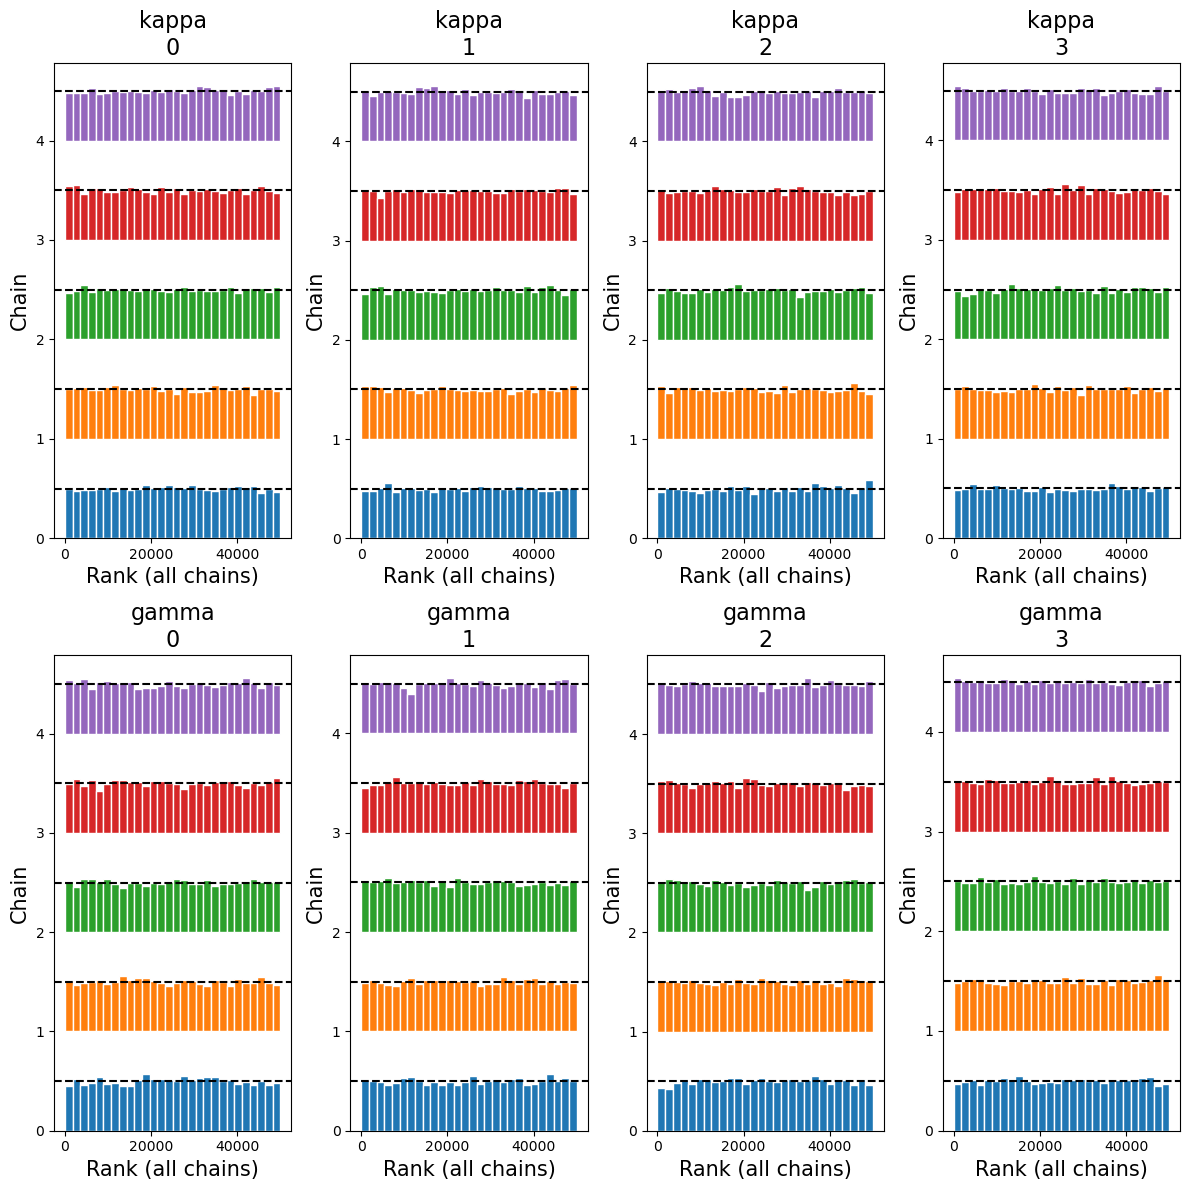

In [10]:
fig, axes = plt.subplots(2,4, figsize=(12,12))
az.plot_rank(trace_prior,var_names=["kappa","gamma"],ax=axes)
plt.tight_layout()

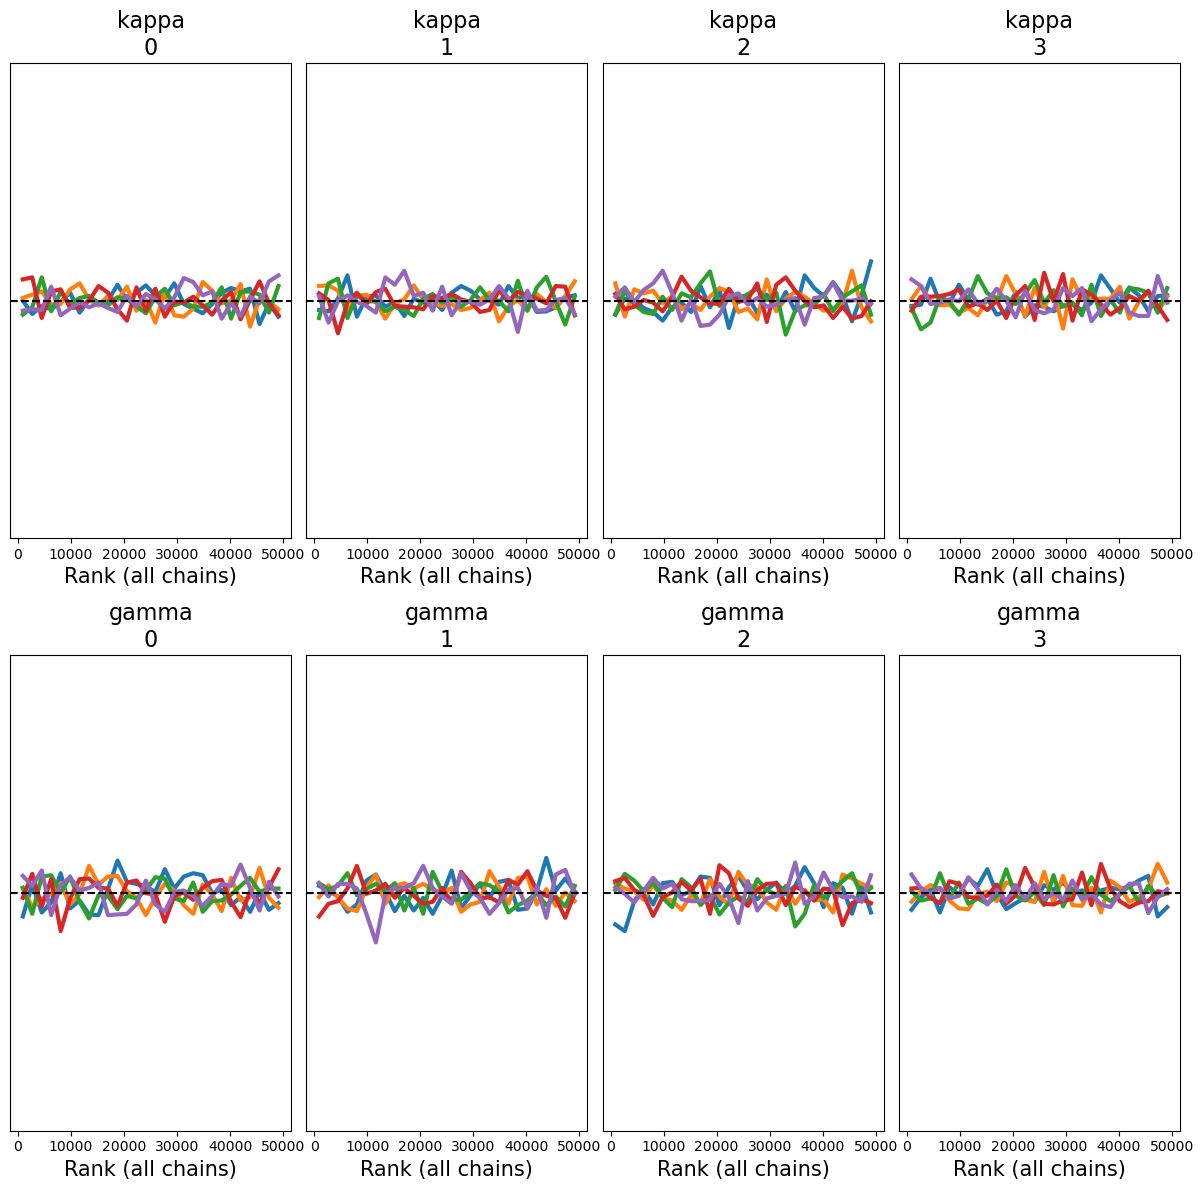

In [11]:
fig, axes = plt.subplots(2,4, figsize=(12,12))
axes = az.plot_rank(trace_prior,var_names=["kappa","gamma"], kind="vlines",vlines_kwargs={'lw':0}, marker_vlines_kwargs={'lw':3},ax=axes)
# plt.ylim([-0.001,0.001])
fig.tight_layout()

In [12]:
summary.head(9)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sd_kappa_hyper,0.671278,0.107321,0.469169,0.864938,0.000559,0.000404,36277.158996,31352.146274,1.000036
kappa[0],0.366672,0.086619,0.215943,0.525460,0.000415,0.000313,48161.278777,34281.844046,1.000205
kappa[1],0.096551,0.023684,0.053300,0.141731,0.000109,0.000077,44127.733738,28072.893038,1.000031
kappa[2],1.630117,0.392649,0.935347,2.390202,0.001986,0.001404,37745.170786,34522.228968,1.000078
kappa[3],1.406582,0.283259,0.883193,1.939301,0.001350,0.000954,42277.702863,33195.249973,1.000131
gamma[0],0.011077,0.002406,0.006782,0.015656,0.000010,0.000007,52252.241794,36311.235676,1.000154
gamma[1],0.010953,0.002573,0.006306,0.015756,0.000011,0.000008,52656.886712,37420.140106,1.000013
gamma[2],0.006149,0.001298,0.003833,0.008646,0.000006,0.000004,44808.755342,34991.757626,1.000129
gamma[3],0.007241,0.001624,0.004350,0.010337,0.000007,0.000005,47990.577565,35431.304548,1.000021
